Using device: cpu
Epoch 1, Batch [100/938], AvgLoss: 1.8464
Epoch 1, Batch [200/938], AvgLoss: 1.1786
Epoch 1, Batch [300/938], AvgLoss: 0.6412
Epoch 1, Batch [400/938], AvgLoss: 0.4913
Epoch 1, Batch [500/938], AvgLoss: 0.3781
Epoch 1, Batch [600/938], AvgLoss: 0.3102
Epoch 1, Batch [700/938], AvgLoss: 0.2815
Epoch 1, Batch [800/938], AvgLoss: 0.2250
Epoch 1, Batch [900/938], AvgLoss: 0.1911
mask_c1u8.shape=(28, 28)
mask_c1u8.dtype=uint8
mask_c1u8.min=0
mask_c1u8.max=255
image_tensor.shape=torch.Size([1, 28, 28])
image_nd.shape=(28, 28)
image_nd.dtype=float32
img_c3f_rgb.shape=(28, 28, 3)
img_c3f_rgb.dtype=float32
img_c3f_rgb.min=-3.198650233571243e-10
img_c3f_rgb.max=1.0
visualization_c3u8_rgb.shape=(28, 28, 3)
visualization_c3u8_rgb.dtype=uint8
visualization_c3u8_rgb.min=0
visualization_c3u8_rgb.max=255
heatmap_c3u8_rgb.shape=(28, 28, 3)
heatmap_c3u8_rgb.dtype=uint8
heatmap_c3u8_rgb.min=0
heatmap_c3u8_rgb.max=255


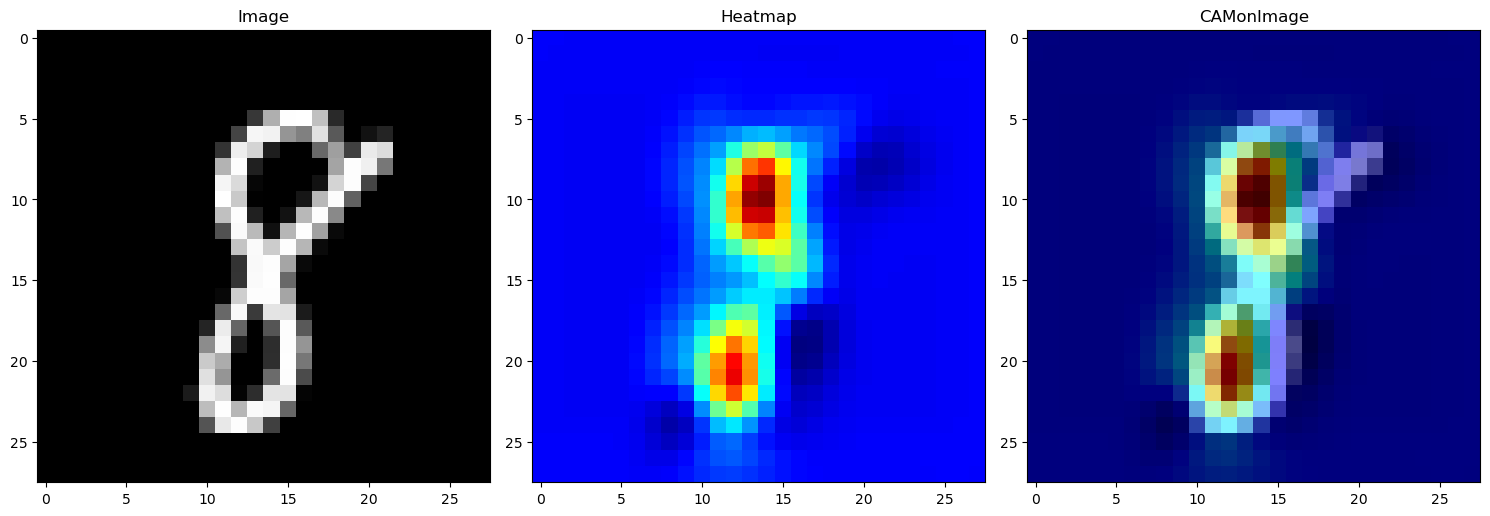

heatmap_tensor.shape=torch.Size([1, 3, 28, 28])
heatmap_tensor.dtype=torch.uint8
heatmap_tensor.min=0
heatmap_tensor.max=255
aaa


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import time
import os
import numpy as np
import torch.nn.functional as F
import cv2
import matplotlib.pyplot as plt

conv5_feature = None

class FCN(nn.Module):
    def __init__(self, num_classes=10):
        super(FCN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        # GAP前卷积层，输出通道数应与类别数(10个数字)相同
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=num_classes, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        #x = self.dropout(x)
        x = F.relu(self.conv2(x))
        #x = self.dropout(x)
        x = F.relu(self.conv3(x))
        #x = self.dropout(x)
        x = F.relu(self.conv4(x))
        #x = self.dropout(x)
        x = self.conv5(x)  # 最后一层卷积不使用ReLU激活
        
        # 使用全局平均池化
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1))  # 输出形状变为(B, C, 1, 1)
        
        # 将四维张量展平为二维，以便进行损失计算
        x = x.view(x.size(0), -1)
        return x

# 定义训练函数
def train(model:FCN, device:torch.device, writer_epoch:SummaryWriter, data_loader:DataLoader, optimizer:optim, criterion, epoch)->None:
    watch_batch_size = 100
    model.train()
    avg_loss = 0.0
    for batch_idx, (data, target) in enumerate(data_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        avg_loss += loss.item()
        if batch_idx % watch_batch_size == (watch_batch_size - 1):  # 每100个batch打印一次
            avg_loss =  avg_loss / watch_batch_size
            writer_epoch.add_scalars('training loss pre batch', {f'avg_loss{epoch+1}': avg_loss}, batch_idx + 1)
            print(f'Epoch {epoch + 1}, Batch [{batch_idx + 1}/{len(data_loader)}], AvgLoss: {avg_loss:.4f}')
            avg_loss = 0.0

# 定义验证函数
def evaluate(model:FCN, device:torch.device, data_loader:DataLoader, criterion) ->tuple[float, float]:
    data_len = 0
    model.eval()
    loss = 0.0
    correct_count = 0.0
    first_batch = next(iter(data_loader))[0]
    # print('first_batch.shape', first_batch.shape)
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            # print(target.shape) # 一个64维的行向量，代表整个64张图的batch中每个图的代表的数字
            # print(data.shape)
            output = model(data)
            # print(output.shape) # 64行10列表示这个batch中的64张图对应到每个数字（0-9）的概率。
            loss += criterion(output, target).item()  # 累积损失
            data_len += 1
            pred = output.argmax(dim=1, keepdim=True)
            correct_count += pred.eq(target.view_as(pred)).sum().item()
    loss = loss / data_len
    accuracy = correct_count / len(data_loader.dataset)
    return accuracy, loss, first_batch

def forward_hook(module, input, output):
    global conv5_feature
    conv5_feature = output

def return_CAM(last_conv_feature_tensor, after_softmax_weight_tensor, size = (28, 28)):
    #print(f'last_conv_feature_tensor.shape={last_conv_feature_tensor.shape}') #[10, 28, 28]
    #print(f'after_softmax_weight_tensor.shape={after_softmax_weight_tensor.shape}') #[10, 1]

    nc, h, w = last_conv_feature_tensor.shape
    last_conv_channels_feature =  last_conv_feature_tensor.reshape((nc, h*w))
    
    last_conv_channels_feature_nd = last_conv_channels_feature.detach().cpu().numpy()
    after_softmax_weight_nd = after_softmax_weight_tensor.detach().cpu().numpy()
    
    cam = after_softmax_weight_nd * last_conv_channels_feature_nd
    #print(f'cam1.shape={cam.shape}') #(10, 784)

    cam = cam.sum(axis=0)
    #print(f'cam2.shape={cam.shape}') #(784,)
    
    cam = cam.reshape(h, w)
    #print(f'cam3.shape={cam.shape}') #(28, 28)

    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    cam_img = np.uint8(255 * cam_img)
    cam_img = cv2.resize(cam_img, size)
    
    return cam_img

def show_cam_on_image(rgb_img_c3f_rgb: np.ndarray,
                      mask_c1u8: np.ndarray,
                      colormap: int = cv2.COLORMAP_JET,
                      image_weight: float = 0.5) -> np.ndarray:
    heatmap_c3u8_bgr = cv2.applyColorMap(mask_c1u8, colormap)
    heatmap_c3u8_rgb = cv2.cvtColor(heatmap_c3u8_bgr, cv2.COLOR_BGR2RGB)
    heatmap_c3f_rgb = cv2.normalize(heatmap_c3u8_rgb, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    cam_c3f_rgb = (1 - image_weight) * heatmap_c3f_rgb + image_weight * rgb_img_c3f_rgb
    cam_c3u8_rgb = cv2.normalize(cam_c3f_rgb, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F).astype(np.uint8)
    
    return cam_c3u8_rgb, heatmap_c3u8_rgb

def main():
    # 设置设备
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f'Using device: {device}')

    # 实例化模型
    # model = FCN().to(device)
    # checkpoint = torch.load('mnist_fcn.pth')
    # model.load_state_dict(checkpoint)
    
    # 加载MNIST数据集
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    validate_dataset = datasets.MNIST('./data', train=False, transform=transform)
    validate_loader = DataLoader(validate_dataset, batch_size=64, shuffle=True)

    data = next(iter(train_loader))
    
    model = FCN().to(device)
    model_name = 'FCN'
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())
    
    # 获取当前时间戳
    timestamp = time.strftime("%Y%m%d-%H%M%S")
    log_dir = f"runs/{model_name}_experiment_{timestamp}"
    os.makedirs(log_dir, exist_ok=True)
    
    # 添加模型结构到TensorBoard
    writer_model = SummaryWriter(log_dir)
    data_iter = iter(train_loader)
    images, _ = next(data_iter)
    writer_model.add_graph(model, images.to(device))
    
    # 注册钩子函数
    model.conv5.register_forward_hook(forward_hook)

    # 训练和验证循环
    num_epochs = 1
    for epoch in range(num_epochs):
        # 初始化writer_epoch
        writer_epoch = SummaryWriter(log_dir)
        
        epoch_start_time = time.time()
        
        train(model, device, writer_epoch, train_loader, optimizer, criterion, epoch)

        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        writer_epoch.add_scalar('epoch_duration (seconds)', epoch_duration, epoch+1)
        
        #print(f'data.len={len(data)}') # 2
        #print(f'data[0].shape={data[0].shape}') # [64, 1, 28, 28]

        image_tensor = data[0][epoch] # 取train_loader第一个batch中的图，具体哪个跟随epoch改变
        
        output = model(image_tensor) 
        mask_c1u8 = return_CAM(conv5_feature, output)
        print(f'mask_c1u8.shape={mask_c1u8.shape}') # (28, 28)
        print(f'mask_c1u8.dtype={mask_c1u8.dtype}') # uint8
        print(f'mask_c1u8.min={mask_c1u8.min()}') # 0
        print(f'mask_c1u8.max={mask_c1u8.max()}') # 255

        print(f'image_tensor.shape={image_tensor.shape}') #[1, 28, 28]
        image_nd = image_tensor.squeeze().numpy()
        print(f'image_nd.shape={image_nd.shape}') #(28, 28)
        print(f'image_nd.dtype={image_nd.dtype}') #float32

        img_rgb = cv2.cvtColor(image_nd, cv2.COLOR_GRAY2RGB)
        img_c3f_rgb = cv2.normalize(img_rgb, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

        print(f'img_c3f_rgb.shape={img_c3f_rgb.shape}') #(28, 28, 3)
        print(f'img_c3f_rgb.dtype={img_c3f_rgb.dtype}') #float32
        print(f'img_c3f_rgb.min={img_c3f_rgb.min()}') # -3.198650233571243e-10
        print(f'img_c3f_rgb.max={img_c3f_rgb.max()}') # 1.0

        visualization_c3u8_rgb, heatmap_c3u8_rgb = show_cam_on_image(img_c3f_rgb, mask_c1u8, image_weight=0.5)
        
        img_c3u8_rgb = cv2.normalize(img_c3f_rgb, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_32F).astype(np.uint8)

        print(f'visualization_c3u8_rgb.shape={visualization_c3u8_rgb.shape}') #(28, 28, 3)
        print(f'visualization_c3u8_rgb.dtype={visualization_c3u8_rgb.dtype}') #uint8
        print(f'visualization_c3u8_rgb.min={visualization_c3u8_rgb.min()}') #0
        print(f'visualization_c3u8_rgb.max={visualization_c3u8_rgb.max()}') #255

        print(f'heatmap_c3u8_rgb.shape={heatmap_c3u8_rgb.shape}') #(28, 28, 3)
        print(f'heatmap_c3u8_rgb.dtype={heatmap_c3u8_rgb.dtype}') #uint8
        print(f'heatmap_c3u8_rgb.min={heatmap_c3u8_rgb.min()}') #0
        print(f'heatmap_c3u8_rgb.max={heatmap_c3u8_rgb.max()}') #255

        # cv2.imshow('heatmap_c3u8_rgb', heatmap_c3u8_rgb) # opencv imshow 强制认为是 BRG，不能正常显示RGB

        fig, axs = plt.subplots(1, 3, figsize=(15, 5))

        axs[0].imshow(img_c3u8_rgb)  # 第一个图的示例数据
        axs[0].set_title('Image')
        axs[1].imshow(heatmap_c3u8_rgb)  # 第二个图的示例数据
        axs[1].set_title('Heatmap')
        axs[2].imshow(visualization_c3u8_rgb)  # 第三个图的示例数据
        axs[2].set_title('CAMonImage')

        plt.tight_layout()
        plt.show()

        img_tensor = torch.from_numpy(img_c3u8_rgb).permute(2, 0, 1).unsqueeze(0)  # 将形状从 [H, W, C] 调整为 [B, C, H, W]
        visualization_tensor = torch.from_numpy(visualization_c3u8_rgb).permute(2, 0, 1).unsqueeze(0) # 将形状从 [H, W, C] 调整为 [B, C, H, W]
        heatmap_tensor = torch.from_numpy(heatmap_c3u8_rgb).permute(2, 0, 1).unsqueeze(0) # 将形状从 [H, W, C] 调整为 [B, C, H, W]

        print(f'heatmap_tensor.shape={heatmap_tensor.shape}') #(1, 3, 28, 28)
        print(f'heatmap_tensor.dtype={heatmap_tensor.dtype}') #uint8
        print(f'heatmap_tensor.min={heatmap_tensor.min()}') #0
        print(f'heatmap_tensor.max={heatmap_tensor.max()}') #255

        cam_images_tensor = torch.cat((img_tensor, heatmap_tensor, visualization_tensor), dim=0)

        writer_epoch.add_images("cam_images", cam_images_tensor, global_step=epoch+1)
        print('aaa')
        train_accuracy, train_loss, batch0 = evaluate(model, device, train_loader, criterion)
        print('bbb')
        validate_accuracy, validate_loss, _ = evaluate(model, device, validate_loader, criterion)
        print('ccc')
        writer_epoch.add_scalars('accurancy', {'train accurancy': train_accuracy, 
                                                'validate accurancy':validate_accuracy},global_step=epoch+1)
        writer_epoch.add_scalars('loss', {'train loss': train_loss, 
                                                    'validate loss':validate_loss},global_step=epoch+1)
        print('ddd')
        img_grid = make_grid(batch0, nrow=8, normalize=False, scale_each=False)
        writer_epoch.add_image(f'batch0_imgs{epoch+1}', img_grid, global_step=None)
        print('eee')
    # 保存训练模型和参数
    torch.save(model.state_dict(), 'mnist_fcn.pth')
    print(f"Model save to mnist_fcn")
    
    input_shape = (1, 1, 28, 28)  # MNIST图像为28x28像素，单通道
    dummy_input = torch.randn(input_shape).to(device)  # 创建一个虚拟输入张量
    onnx_file_path = "mnist_fcn_onnx.onnx"
    torch.onnx.export(model, dummy_input, onnx_file_path, export_params=True, opset_version=17, do_constant_folding=True)

    print(f"Train finished, Export Model to {onnx_file_path}")

    writer_epoch.close()
    
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()
    
if __name__ == "__main__":
    main()